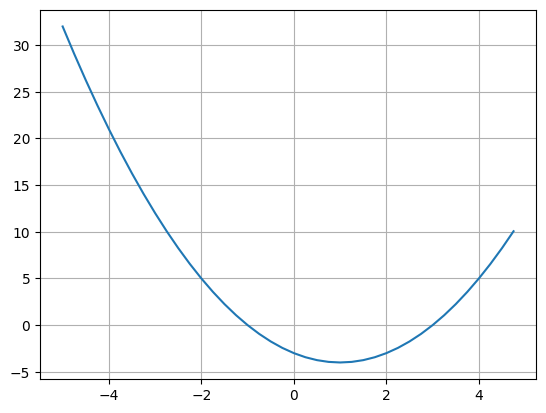

In [3]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


def f(x):
    return x**2 - 2*x - 3
f(5)

xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)
plt.grid()


In [4]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot



In [5]:
class Value:

    def __init__(self,data,_children=(),_op='',label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    def __repr__(self):
        return f'Value(data={self.data})'
    def __add__(self, other):
            out =  Value(self.data + other.data, (self, other), '+')

            def _backward():
                self.grad += 1.0 * out.grad
                other.grad += 1.0 * out.grad    
            out._backward = _backward
            return out

    def __mul__(self, other):
        out =  Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    def tanh(self):
        x= self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1) 
        out =  Value(t,(self,), 'tanh')
        def _backward():
            self.grad += (1-t**2)*out.grad
        out._backward = _backward
        return out
a= Value(2.0,label='a')
b = Value(-3.0,label='b')
c = Value(10.0,label='c')
d = a*b;d.label='d'
e= d+c;e.label='e'
f = Value(-2.0,label='f')
L =e *f;L.label='L'
L


Value(data=-8.0)

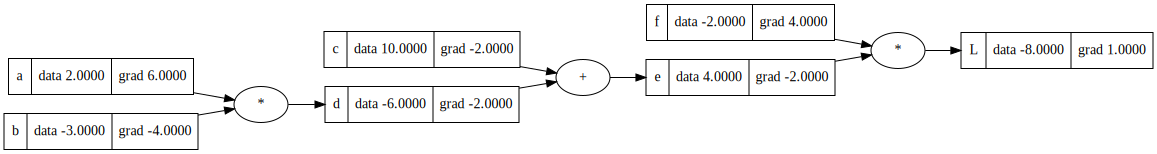

In [6]:
e.grad = -2.0
f.grad = 4.0
c.grad = -2.0
d.grad = -2.0
L.grad = 1.0
a.grad = 6.0
b.grad = -4.0
draw_dot(L)

In [7]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
e.data += 0.01 * e.grad

d= a*b
e= d+c
L=e*f
print(L.data) 

-7.4352


In [8]:
def lol():
    h=0.001
    a= Value(2.0,label='a')
    b = Value(-3.0,label='b')
    c = Value(10.0,label='c')
    d = a*b;d.label='d'
    e= d+c;e.label='e'
    f = Value(-2.0,label='f')
    L =e *f;L.label='L'
    L1 = L.data

    a= Value(2.0,label='a')
    b = Value(-3.0,label='b')
    c = Value(10.0,label='c')   
    c += Value(h)
    d = a*b;d.label='d'
    e= d+c;e.label='e'
    f = Value(-2.0,label='f')
    L =e *f;L.label='L'
    L2 = L.data

    print((L1-L2)/h)
lol()

1.9999999999988916


In [13]:
#inputs x1,x2
x1 = Value(2.0,label='x1')
x2 = Value(0.0,label='x2')
#weights w1,w2
w1 = Value(-3.0,label='w1')
w2 = Value(1.0,label='w2')
#bias of the neuron
b = Value(6.88137358701995432,label='b')
#x1w1+x2w2 +b
x1w1 = x1*w1;x1w1.label='x1w1'
x2w2 = x2*w2;x2w2.label='x2w2'
x1w1x2w2 = x1w1+x2w2;x1w1x2w2.label='x1w1 + x2w2'
n= x1w1x2w2+b;n.label='n'
o = n.tanh();o.label='0'


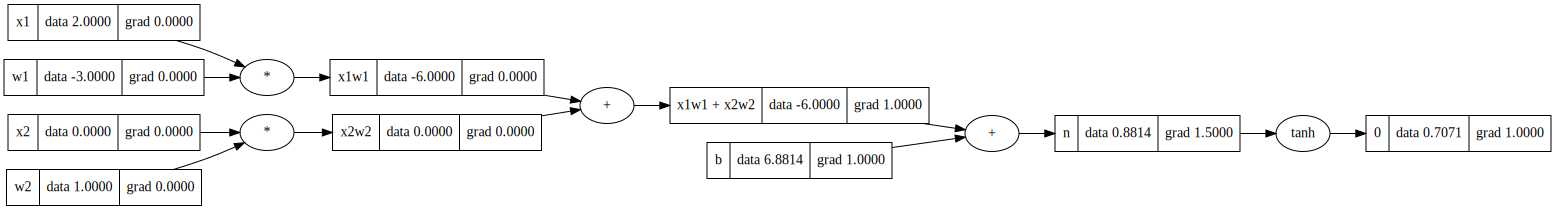

In [12]:
o.grad = 1.0
o._backward()
draw_dot(o)